# Setup

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset and Visualisation

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
7


In [0]:
def imshow(img, title):
    plt.figure(figsize=(batch_size*4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))

    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

    return images, labels

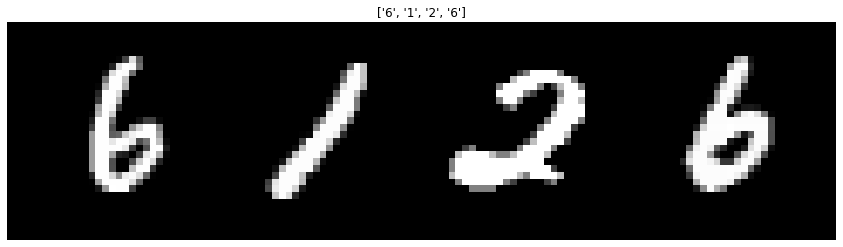

In [8]:
images, labels = show_batch_images(trainloader)

# BatchNorm

In [0]:
class ffnn(nn.Module):
    def __init__(self):
        super(ffnn, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [0]:
class ffnn_bn(nn.Module):
    def __init__(self):
        super(ffnn_bn, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [11]:
model = ffnn()
print(model)

ffnn(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [12]:
model_bn = ffnn_bn()
print(model_bn)

ffnn_bn(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [0]:
batch_size = 512

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [0]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

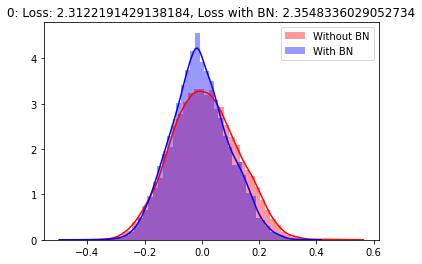

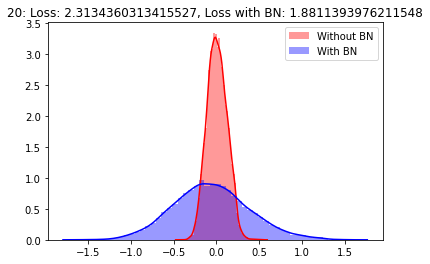

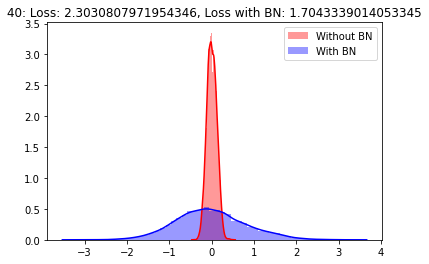

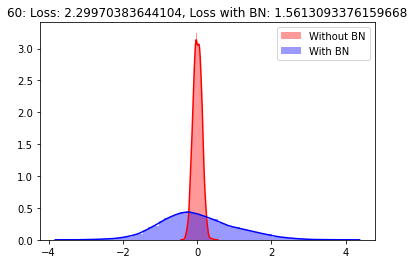

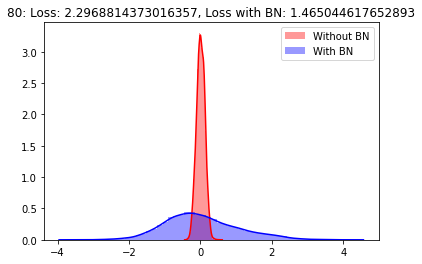

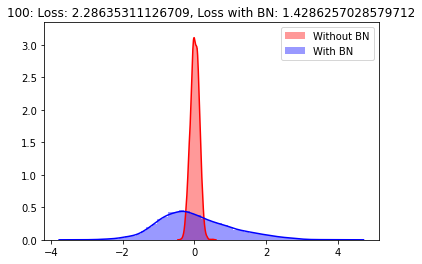

--------------------


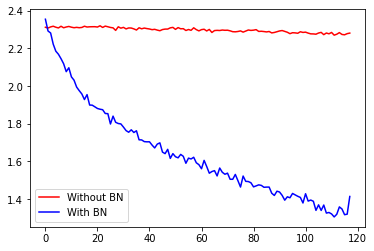

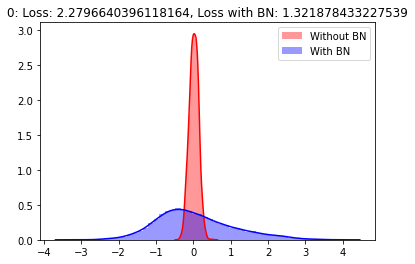

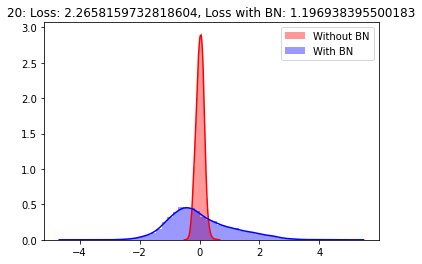

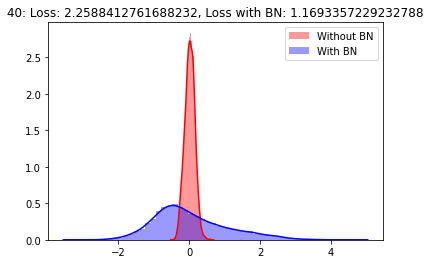

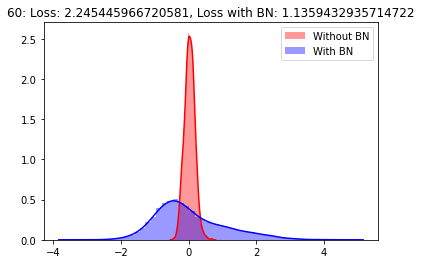

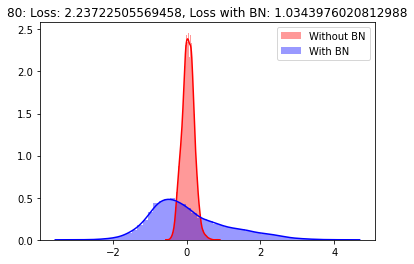

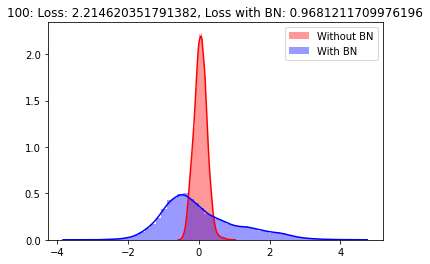

--------------------


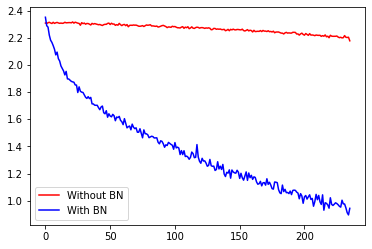

In [16]:
loss_arr = []
loss_bn_arr = []

epochs = 2

for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

        if i%20 == 0:
            
            inputs = inputs.view(inputs.size(0), -1)

            model.eval()
            model_bn.eval()

            a = model.classifier[0](inputs)
            a = model.classifier[1](a)
            a = model.classifier[2](a)
            a = a.detach().numpy().ravel()
            sns.distplot(a, kde=True, color='r', label='Without BN')

            b = model_bn.classifier[0](inputs)
            b = model_bn.classifier[1](b)
            b = model_bn.classifier[2](b)
            b = model_bn.classifier[3](b)
            b = model_bn.classifier[4](b)
            b = b.detach().numpy().ravel()
            sns.distplot(b, kde=True, color='b', label='With BN')

            plt.title('{}: Loss: {}, Loss with BN: {}'.format(i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)

            model.train()
            model_bn.train()

    print('--------------------')

    plt.plot(loss_arr, 'r', label='Without BN')
    plt.plot(loss_bn_arr, 'b', label='With BN')
    plt.legend()
    plt.show()

# Dropout

In [0]:
N = 50
noise = 0.3

X_train = torch.unsqueeze(torch.linspace(-1,1,N), 1)
Y_train = X_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

X_test = torch.unsqueeze(torch.linspace(-1,1,N), 1)
Y_test = X_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

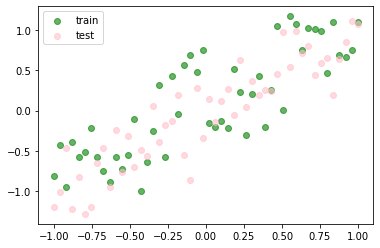

In [18]:
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='green', alpha=0.6, label='train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='pink', alpha=0.6, label='test')
plt.legend()
plt.show()

In [0]:
model = nn.Sequential(
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100,1)
)

model_drop = nn.Sequential(
    nn.Linear(1, 100),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(100, 1)
)

In [0]:
opt = optim.Adam(model.parameters(), lr=0.01)
opt_drop = optim.Adam(model_drop.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

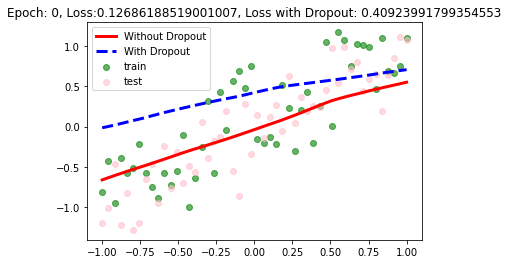

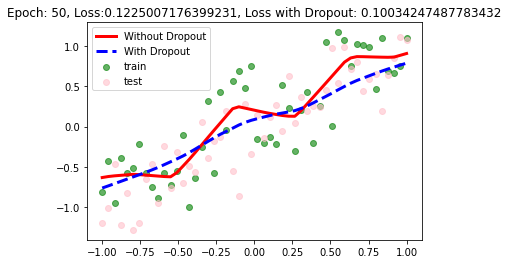

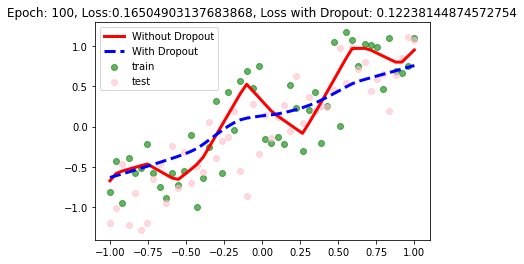

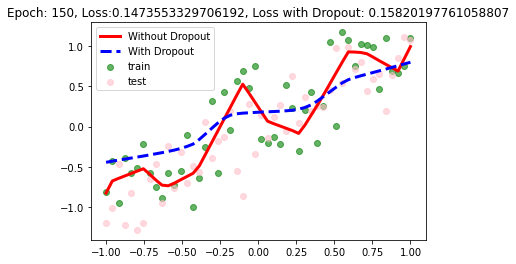

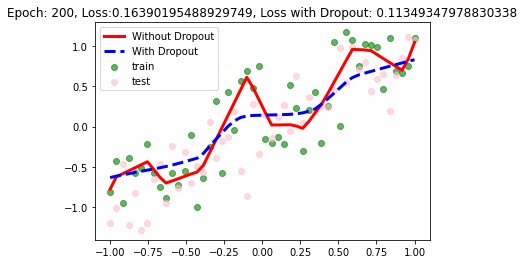

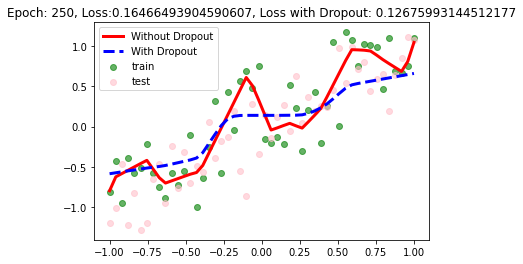

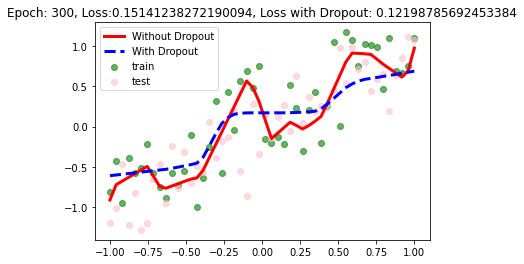

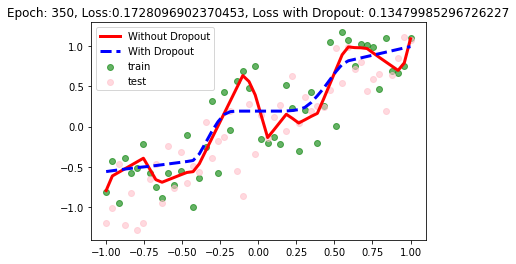

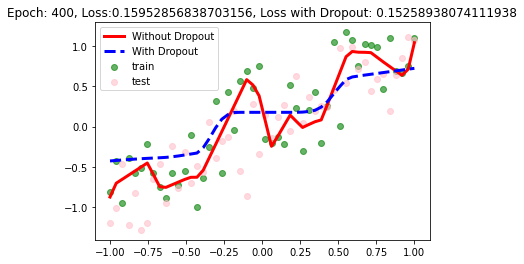

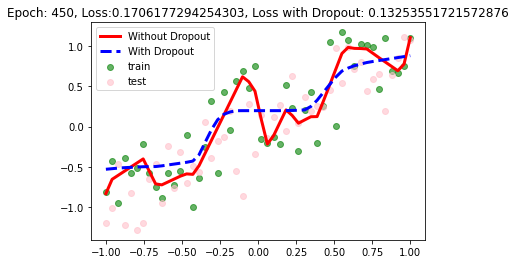

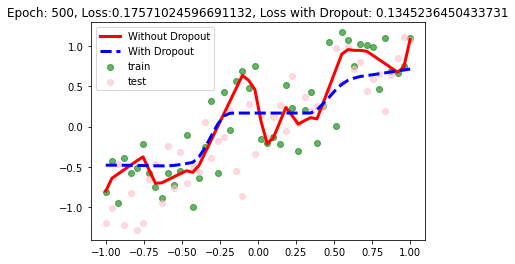

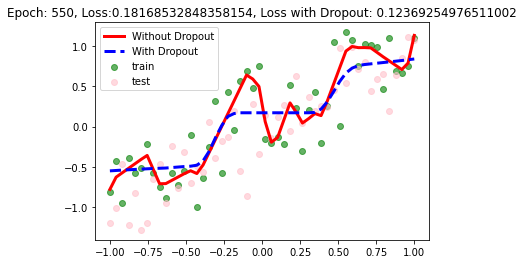

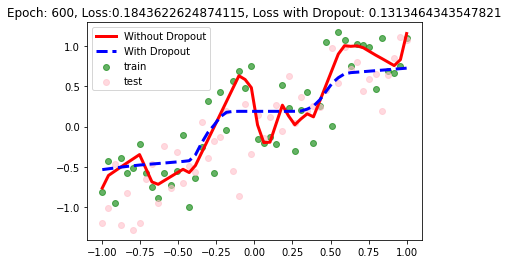

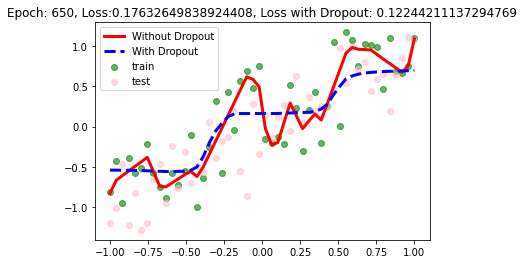

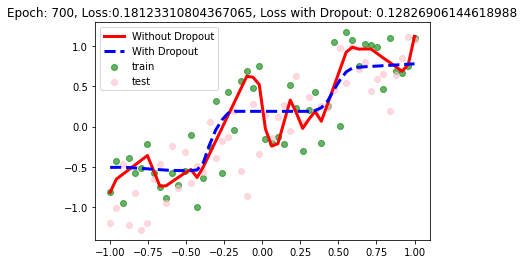

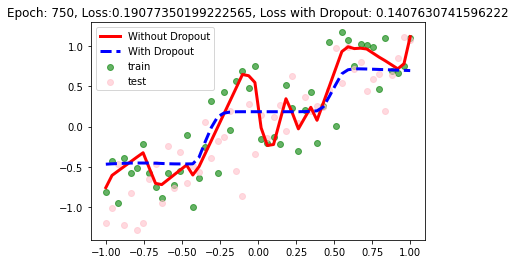

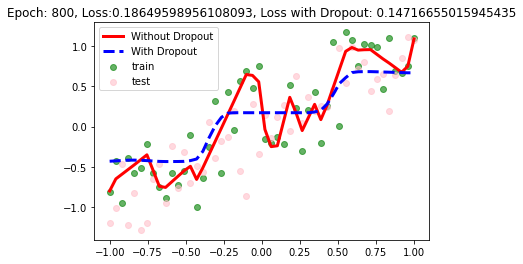

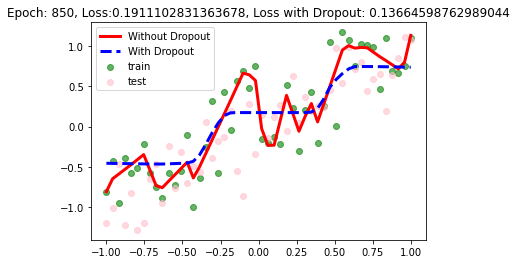

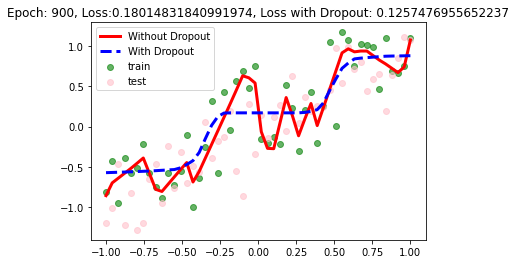

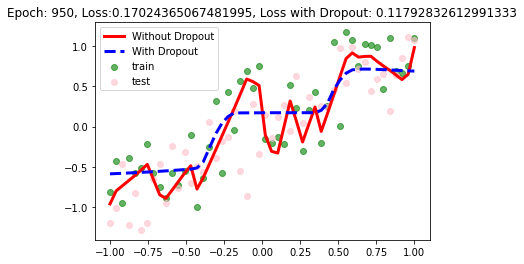

In [21]:
epochs = 1000

for epoch in range(epochs):

    pred = model(X_train)
    loss = loss_fn(pred, Y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    pred_drop = model_drop(X_train)
    loss_drop = loss_fn(pred_drop, Y_train)
    opt_drop.zero_grad()
    loss_drop.backward()
    opt_drop.step()

    if epoch%50 == 0:
        
        model.eval()
        model_drop.eval()
        
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, Y_test)

        test_pred_drop = model_drop(X_test)
        test_loss_drop = loss_fn(test_pred_drop, Y_test)

        plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='green', alpha=0.6, label='train')
        plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='pink', alpha=0.6, label='test')
        plt.plot(X_test.data.numpy(), test_pred.data.numpy(), 'r-', lw=3, label='Without Dropout')
        plt.plot(X_test.data.numpy(), test_pred_drop.data.numpy(), 'b--', lw=3, label='With Dropout')
        plt.title('Epoch: {}, Loss:{}, Loss with Dropout: {}'.format(epoch, test_loss, test_loss_drop))
        plt.legend()

        model.train()
        model_drop.train()

        plt.pause(0.5)